In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as si
from mpl_toolkits.mplot3d import Axes3D
import os

In [3]:
data = yf.download("CSCO", start="2020-12-01", end="2021-12-01")

[*********************100%***********************]  1 of 1 completed


In [4]:
cp = data['Adj Close']
cp.head()

Date
2020-12-01    42.299648
2020-12-02    42.639675
2020-12-03    42.853409
2020-12-04    43.115715
2020-12-07    43.086567
Name: Adj Close, dtype: float64

In [5]:
cp.tail()

Date
2021-11-23    55.299999
2021-11-24    55.540001
2021-11-26    54.669998
2021-11-29    55.759998
2021-11-30    54.840000
Name: Adj Close, dtype: float64

In [6]:
cp.describe()

count    252.000000
mean      51.312041
std        4.847984
min       42.299648
25%       46.827143
50%       52.240414
75%       55.141863
max       59.130543
Name: Adj Close, dtype: float64

array([<AxesSubplot:xlabel='Date'>], dtype=object)

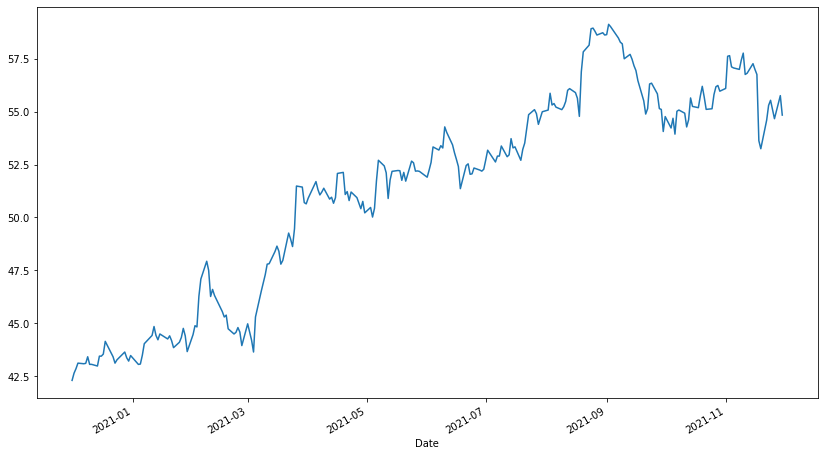

In [7]:
cp.plot(figsize=(14, 8), subplots=True)

In [8]:
log_return = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

In [9]:
vol = np.sqrt(252) * log_return.std()
print('The annualised volatility is', round(vol*100,2), '%')

The annualised volatility is 18.25 %


array([<AxesSubplot:xlabel='Date'>], dtype=object)

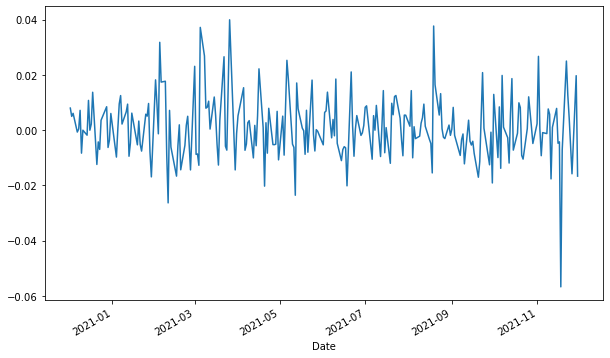

In [10]:
log_return.dropna(inplace=True)
log_return.plot(subplots=True, figsize=(10, 6))

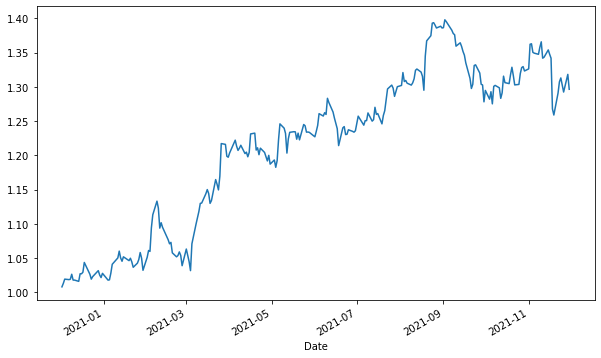

In [11]:
log_return.cumsum().apply(np.exp).plot(figsize=(10, 6));

## Option Pricing - Binomial Tree Methodology

In [12]:
S = cp[-1]
print('The spot price is', round(S,2))

The spot price is 54.84


In [13]:
S0 = 54.84              # spot stock price 30/11/2021
K = 56                  # strike
T = 1/12                # maturity 
r = 0.0144                 #10 year risk free rate - Bloomberg on 02/12/2021
sig = 0.1825               # diffusion coefficient or volatility annualized.
q = 0.0263              # Forward dividend and yield sourced from yahoofinance on 02/12/2021 at 4:29pm.
N = 3                   # number of periods or number of time steps  
payoff = "call"          # payoff 

In [14]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor

In [15]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1
S

array([[54.84      , 56.53367743, 58.27966237, 60.07957026],
       [ 0.        , 53.197063  , 54.84      , 56.53367743],
       [ 0.        ,  0.        , 51.60334631, 53.197063  ],
       [ 0.        ,  0.        ,  0.        , 50.05737536]])

In [16]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p, q

(0.49897206327098853, 0.5010279367290115)

In [17]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[0.        , 0.        , 0.        , 4.07957026],
       [0.        , 0.        , 0.        , 0.53367743],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [18]:
# for European Option
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = round(np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1]),5)
V

array([[0.70567   , 1.28151   , 2.30206   , 4.07957026],
       [0.        , 0.13276   , 0.26618   , 0.53367743],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [19]:
print('European ' + payoff, str (V[0,0]))

European call 0.70567


## Option Pricing - Black Scholes Methodology

In [20]:
def euro_option_bsm(S, K, T, r, q, sig, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #q: continuous dividend yield
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (sig * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (sig * np.sqrt(T))
    if payoff == "call":
        option_value = round ((S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)),4)
    elif payoff == "put":
        option_value =  - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [48]:
xp = euro_option_bsm(54.84, 56, 1/12, 0.0144, 0.0263, 0.1825, 'call')

In [49]:
print('Call option Premium is',xp)

Call option Premium is 0.6552


# Greeks

## 1. Delta

In [25]:
def delta(S, K, T, r, q, sig, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sig ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * sig ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(- q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(- q * T) * si.norm.cdf(- d1, 0.0, 1.0)
    
    return delta

In [26]:
S = np.linspace(50, 60, 12)
T = np.linspace(0.5, 2, 10)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], 56, T[i], 0.0144, 0.0263, 0.1825, 'call')

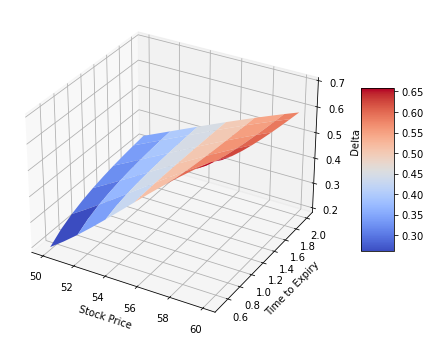

In [27]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [28]:
d = delta(54.84, 56, 1/12, 0.0144, 0.0263, 0.1825, 'call')
print('The value of Delta is', d.round(4),'.','If the stock price increase 1 dollar, then the value of the option will increase $', d.round(4), '.')

The value of Delta is 0.3476 . If the stock price increase 1 dollar, then the value of the option will increase $ 0.3476 .


## 2. Gamma

In [29]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- r * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [30]:
gamma(54.84, 56, 1/12, 0.0144, 0.0263, 0.1825, 'call')

0.12782786928027362

In [31]:
S = np.linspace(50,60,10)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 56, 1/12, 0.0144, 0.0263, 0.1825, 'call')

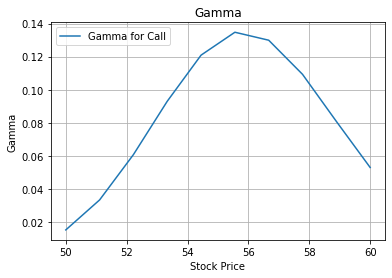

In [32]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call'])

In [33]:
S = np.linspace(50, 60, 20)
T = np.linspace(0.5, 2, 10)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], 56.00, T[i], 0.0144, 0.0263, 0.1825, 'call')

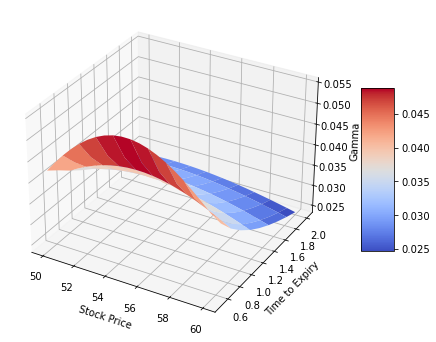

In [34]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

## 3. Vega

In [35]:
def vega(S, K, T, r, q, sig, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [36]:
S = np.linspace(50, 60, 20)
T = np.linspace(0.5, 2, 10)
Vega = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Vega[i,j] = vega(S[j], 56.00, T[i], 0.0144, 0.0263, 0.1825, 'call')

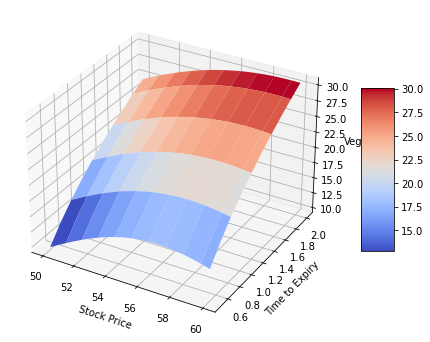

In [37]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Vega, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [38]:
v = vega(54.84, 58, 1/12, 0.0144, 0.0263, 0.1825, 'call')
print('The value of Vega is', v.round(4),'.','If the volatility increases 1%, then the value of the option will increase $', v.round(4)*0.01, '.')

The value of Vega is 3.6089 . If the volatility increases 1%, then the value of the option will increase $ 0.036089 .


## 4. Theta


In [39]:
def theta(S, K, T, r, q, sig, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sig ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * sig ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [40]:
S = np.linspace(50, 60, 20)
T = np.linspace(0.5, 2, 10)
Theta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Theta[i,j] = theta(S[j], 56.00, T[i], 0.0144, 0.0263, 0.1825, 'call')

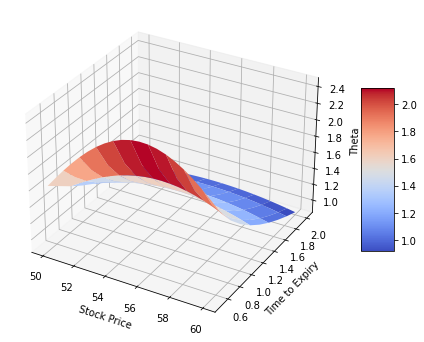

In [41]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [42]:
theta(54.84, 56, 1/12, 0.0144, 0.0263, 0.1825, 'call')

6.158495053888293

## 5. RHO

In [43]:
def rho(S, K, T, r, q, sig, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [44]:
S = np.linspace(30, 50, 20)
T = np.linspace(0.5, 2, 10)
Rho = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Rho[i,j] = rho(S[j], 56.00, T[i], 0.0144, 0.0263, 0.1825, 'call')

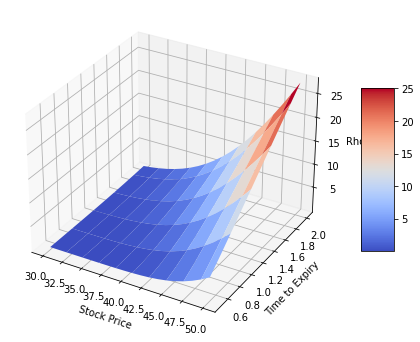

In [45]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Rho, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [46]:
rho(54.84, 56, 1/12, 0.0144, 0.0263, 0.1825, 'call')

1.5338228863606678

In [47]:
r = round(rho(54.84, 56, 1/12, 0.0144, 0.0263, 0.1825, 'call'),4)
print('The value of Rho is', r.round(4),'.','If the interest rate increases 1%, then the value of the option will increase by $', r.round(4)*0.01, '.')

The value of Rho is 1.5338 . If the interest rate increases 1%, then the value of the option will increase by $ 0.015338000000000001 .
